<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Чтение-csv-файла-с-данными-(экспортирован-из-Geoscan)" data-toc-modified-id="Чтение-csv-файла-с-данными-(экспортирован-из-Geoscan)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Чтение csv файла с данными (экспортирован из Geoscan)</a></span></li><li><span><a href="#Расчет-частоты-дискретизации-и-шкалы-времени" data-toc-modified-id="Расчет-частоты-дискретизации-и-шкалы-времени-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Расчет частоты дискретизации и шкалы времени</a></span></li><li><span><a href="#Проведение-преобразования-Гильберта" data-toc-modified-id="Проведение-преобразования-Гильберта-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проведение преобразования Гильберта</a></span></li><li><span><a href="#AGC" data-toc-modified-id="AGC-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>AGC</a></span></li><li><span><a href="#Построение-разрезов" data-toc-modified-id="Построение-разрезов-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Построение разрезов</a></span></li><li><span><a href="#Тест-другого-расчета-мгновенной-фазы-(как-в-книге-Старовойтова,-2008)" data-toc-modified-id="Тест-другого-расчета-мгновенной-фазы-(как-в-книге-Старовойтова,-2008)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тест другого расчета мгновенной фазы (как в книге Старовойтова, 2008)</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import math as mt

# Преобразование Гильберта для георадарных данных

### Чтение csv файла с данными (экспортирован из Geoscan)

In [2]:
path_to_file = 'C:\\Users\\Admin\\Desktop\\Experiments_code\\13-63m_gpr.csv'

In [3]:
data = pd.read_csv(path_to_file, delimiter=',', header=None, low_memory=False)

Получаем время записи

In [4]:
trace_time = float(data.iat[len(data) - 1, 0][:9])

Удаляем последнюю строку (из нее мы уже получили время, больше там ничего не было, только NaN значения)

In [5]:
data.drop(index=len(data) - 1, inplace=True)

Удаляем последние 2 колонки, в них астрономическое время и непонятный показатель

In [6]:
data.drop(columns=[data.shape[1] - 2, data.shape[1] - 1], inplace=True)

Получаем координаты по X и переводим сразу в метры

In [7]:
x_coord = data[0].to_numpy().astype('int') / 1000

Получаем радарные трассы

In [8]:
traces = data.to_numpy()
traces = np.delete(traces, 0, axis = 1)

### Расчет частоты дискретизации и шкалы времени

In [9]:
fs = len(traces[0]) / trace_time

In [10]:
time = np.arange(1 / fs, trace_time + (1 / fs), 1 / fs)

### Проведение преобразования Гильберта

In [11]:
amplitude_envelope = []
instantaneous_phase = []
instantaneous_frequency = []

for i in range(len(traces)):
    trace = traces[i]

    analytic_signal = hilbert(trace)

    amplitude_envelope.append(np.abs(analytic_signal))
    
    phase = np.unwrap(np.angle(analytic_signal))
    
    instantaneous_phase.append(phase)

    instantaneous_frequency.append(np.diff(phase) / (2 * np.pi) * fs)

In [12]:
amplitude_envelope = np.array(amplitude_envelope)
instantaneous_phase = np.array(instantaneous_phase)
instantaneous_frequency = np.array(instantaneous_frequency)

### AGC

Производим автоматическую регулировку амплитуд (АРА) с шириной окна 20

In [13]:
amplitude_envelope_AGC = amplitude_envelope.copy()
w = 20
for i in range(len(traces)):
    amp = 0
    for j in range(w // 2, len(traces[0]) - w // 2):
        amp = np.sqrt(1 / w * np.sum((amplitude_envelope[i, j - w // 2:j + w // 2]) ** 2))
        if amp != 0:
            amplitude_envelope_AGC[i, j] = amplitude_envelope[i, j] / amp

### Построение разрезов

Строим временной разрез амплитуд огибающей (пока без АРА)

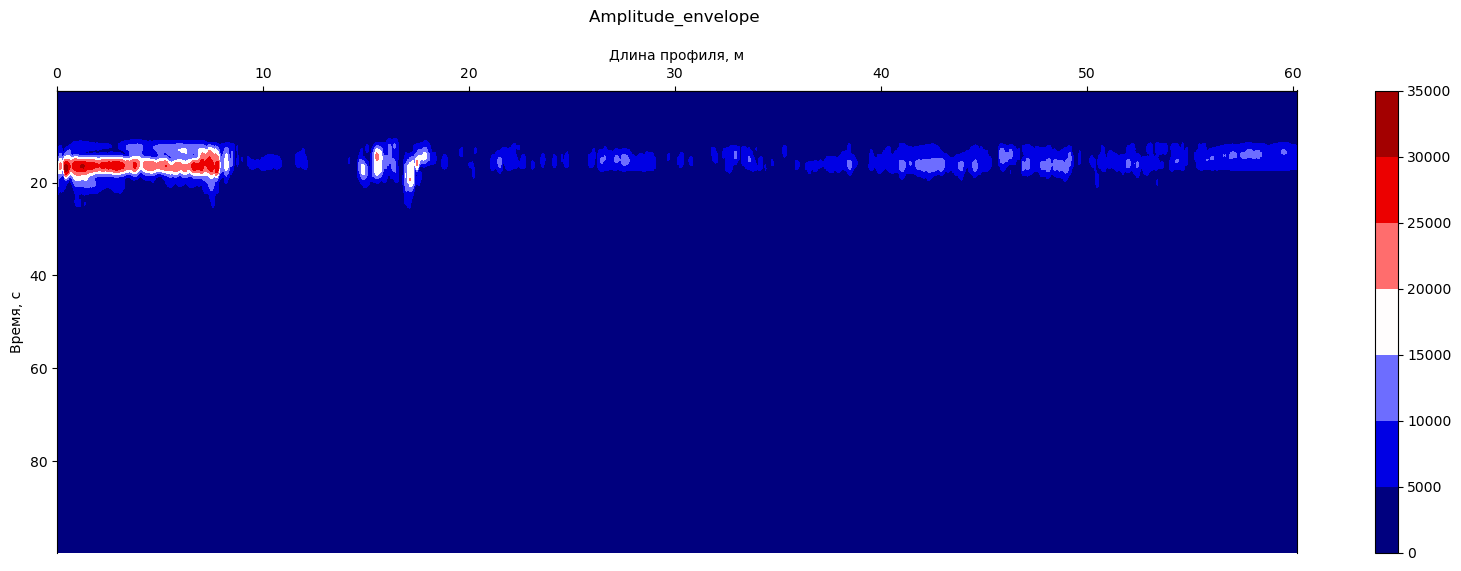

In [14]:
fig1 = plt.figure(figsize=(20, 6))
cf1 = plt.contourf(x_coord, time, amplitude_envelope.T, cmap='seismic')
plt.colorbar(cf1)
plt.title('Amplitude_envelope \n')

ax = plt.gca()
ax.invert_yaxis()
ax.spines['bottom'].set_position(('axes', 1))
ax.tick_params(axis='x', top=True, bottom=False, labelbottom=False, labeltop=True)
ax.set_xlabel('Длина профиля, м', labelpad=-30)
ax.set_ylabel('Время, с')
plt.show()

Тоже самое, но в серых тонах (как на экране прибора)

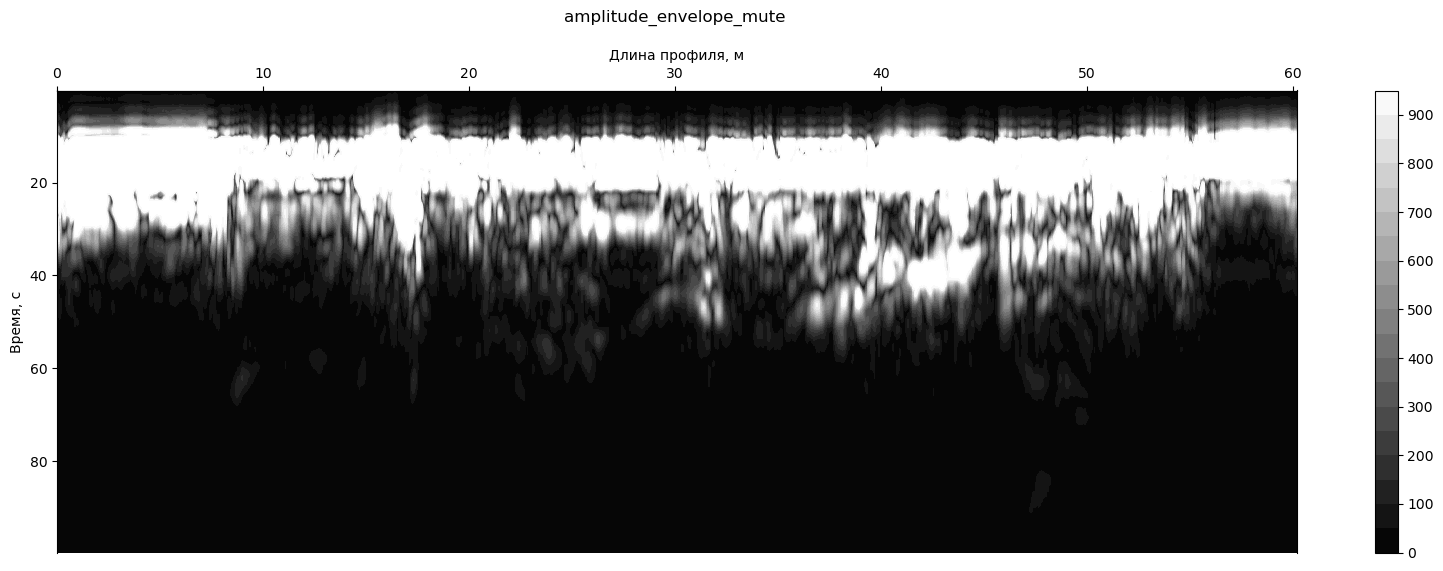

In [15]:
lev_region = np.arange(0, 1000, 50)

fig1 = plt.figure(figsize=(20, 6))
cf1 = plt.contourf(x_coord, time, amplitude_envelope.T, levels=lev_region, cmap='gray')
plt.colorbar(cf1)
plt.title('amplitude_envelope_mute \n')

ax = plt.gca()
ax.invert_yaxis()
ax.spines['bottom'].set_position(('axes', 1))
ax.tick_params(axis='x', top=True, bottom=False, labelbottom=False, labeltop=True)
ax.set_xlabel('Длина профиля, м', labelpad=-30)
ax.set_ylabel('Время, с')
plt.show()

Теперь с АРА

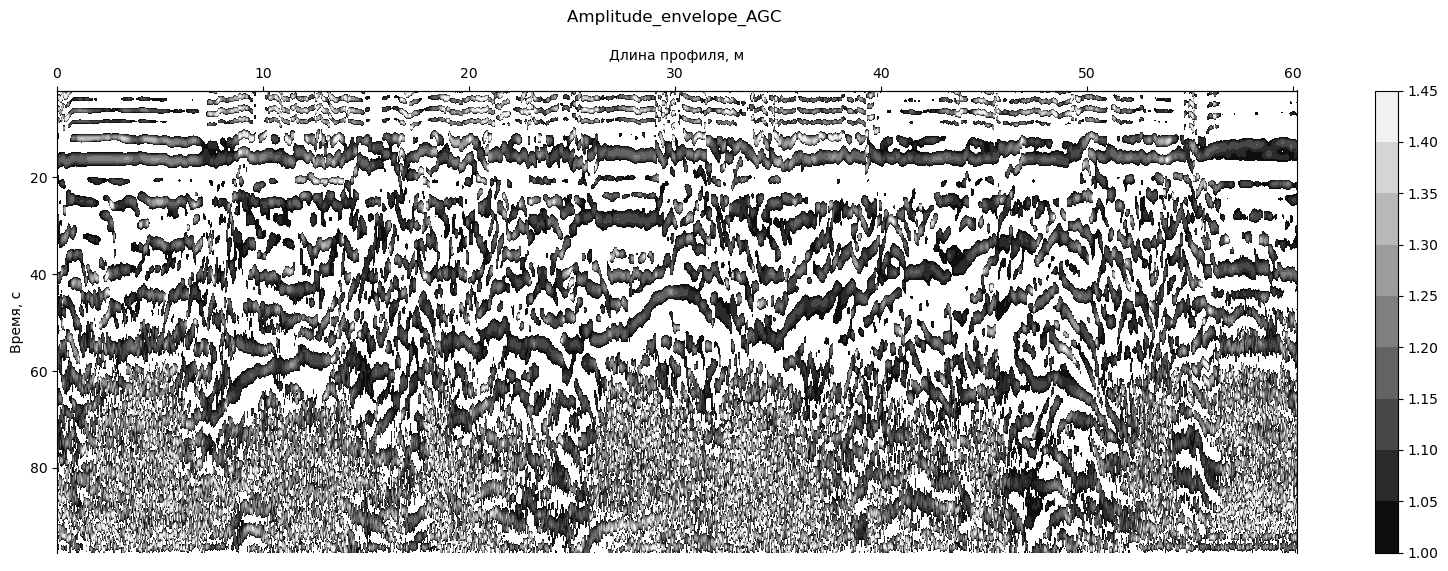

In [16]:
lev_region = np.arange(1, 1.5, 0.05)

fig1 = plt.figure(figsize=(20, 6))
cf1 = plt.contourf(x_coord, time[10:500], amplitude_envelope_AGC[:, 10:500].T, levels=lev_region, cmap='gray')
plt.colorbar(cf1)
plt.title('Amplitude_envelope_AGC \n')

ax = plt.gca()
ax.invert_yaxis()
ax.spines['bottom'].set_position(('axes', 1))
ax.tick_params(axis='x', top=True, bottom=False, labelbottom=False, labeltop=True)
ax.set_xlabel('Длина профиля, м', labelpad=-30)
ax.set_ylabel('Время, с')
plt.show()

Теперь временной разрез мгновенной фазы

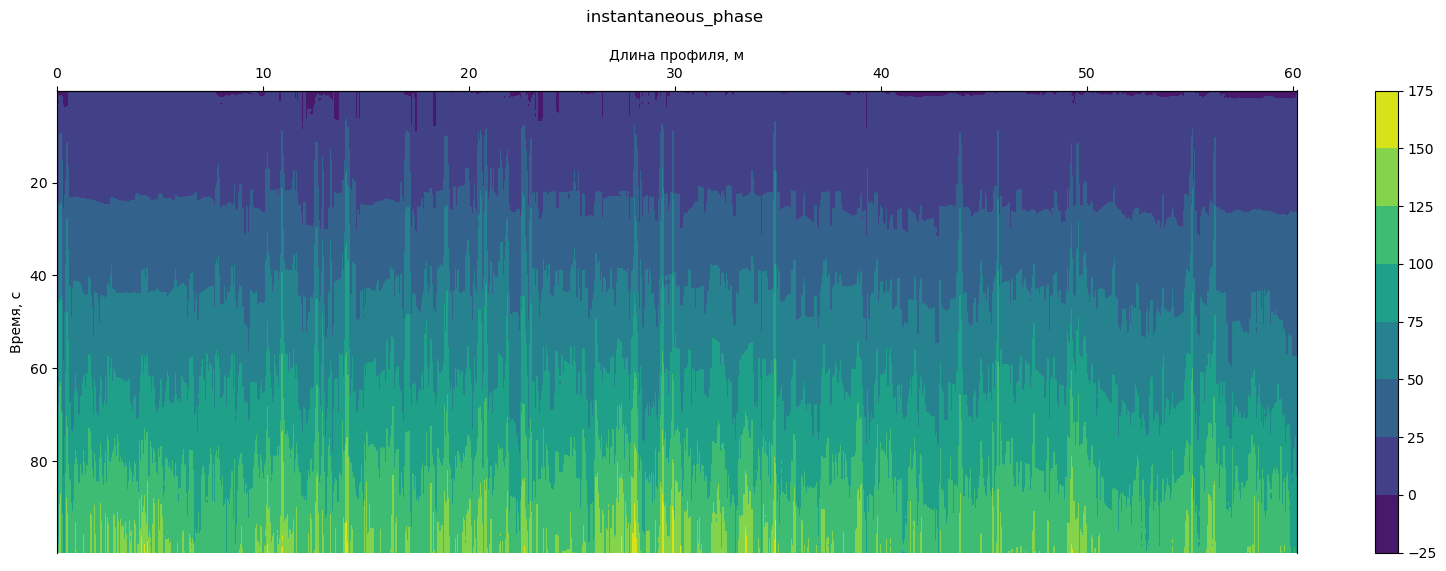

In [17]:
fig1 = plt.figure(figsize=(20, 6))
cf1 = plt.contourf(x_coord, time, instantaneous_phase.T)
plt.colorbar(cf1)
plt.title('instantaneous_phase \n')

ax = plt.gca()
ax.invert_yaxis()
ax.spines['bottom'].set_position(('axes', 1))
ax.tick_params(axis='x', top=True, bottom=False, labelbottom=False, labeltop=True)
ax.set_xlabel('Длина профиля, м', labelpad=-30)
ax.set_ylabel('Время, с')
plt.show()

Ну и наконец - мгновенной частоты

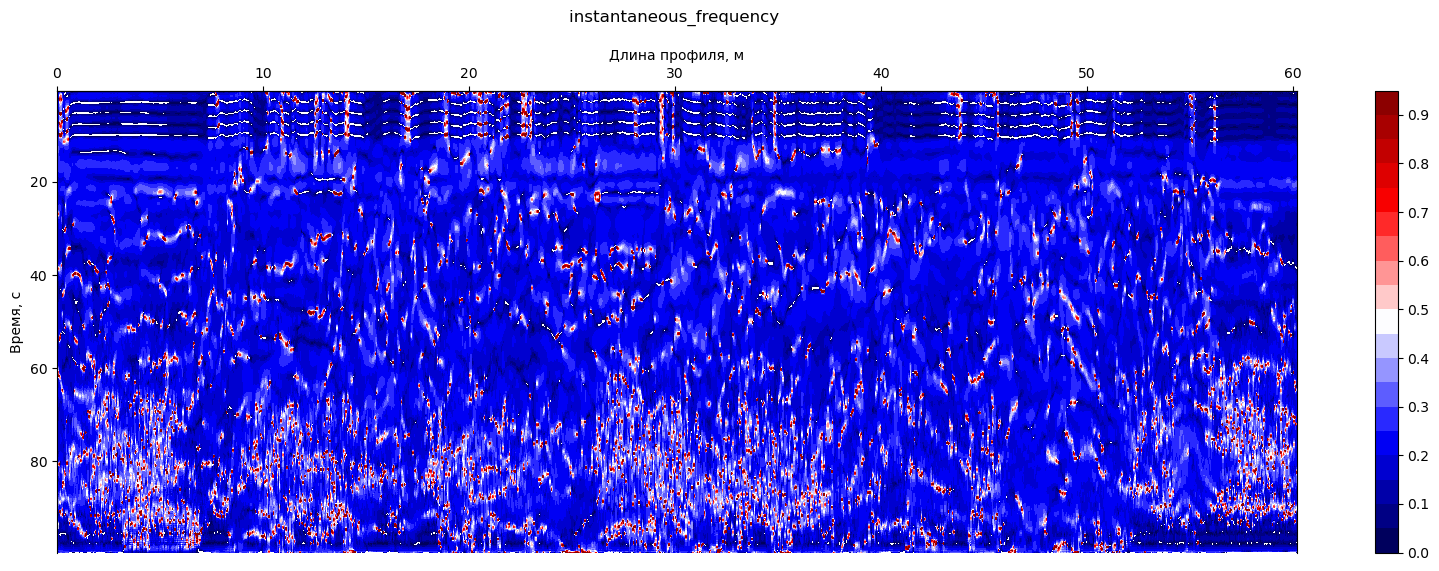

In [18]:
lev_region = np.arange(0, 1, 0.05)

fig1 = plt.figure(figsize=(20, 6))
cf1 = plt.contourf(x_coord, time[1:], instantaneous_frequency.T, levels=lev_region, cmap='seismic')
plt.colorbar(cf1)
plt.title('instantaneous_frequency \n')

ax = plt.gca()
ax.invert_yaxis()
ax.spines['bottom'].set_position(('axes', 1))
ax.tick_params(axis='x', top=True, bottom=False, labelbottom=False, labeltop=True)
ax.set_xlabel('Длина профиля, м', labelpad=-30)
ax.set_ylabel('Время, с')
plt.show()

### Тест другого расчета мгновенной фазы (как в книге Старовойтова, 2008)

In [19]:
instantaneous_phase_2 = []

for i in range(len(traces)):
    trace = traces[i]

    analytic_signal = hilbert(trace)

    instantaneous_phase_2.append(np.angle(analytic_signal))

instantaneous_phase_2 = np.array(instantaneous_phase_2)

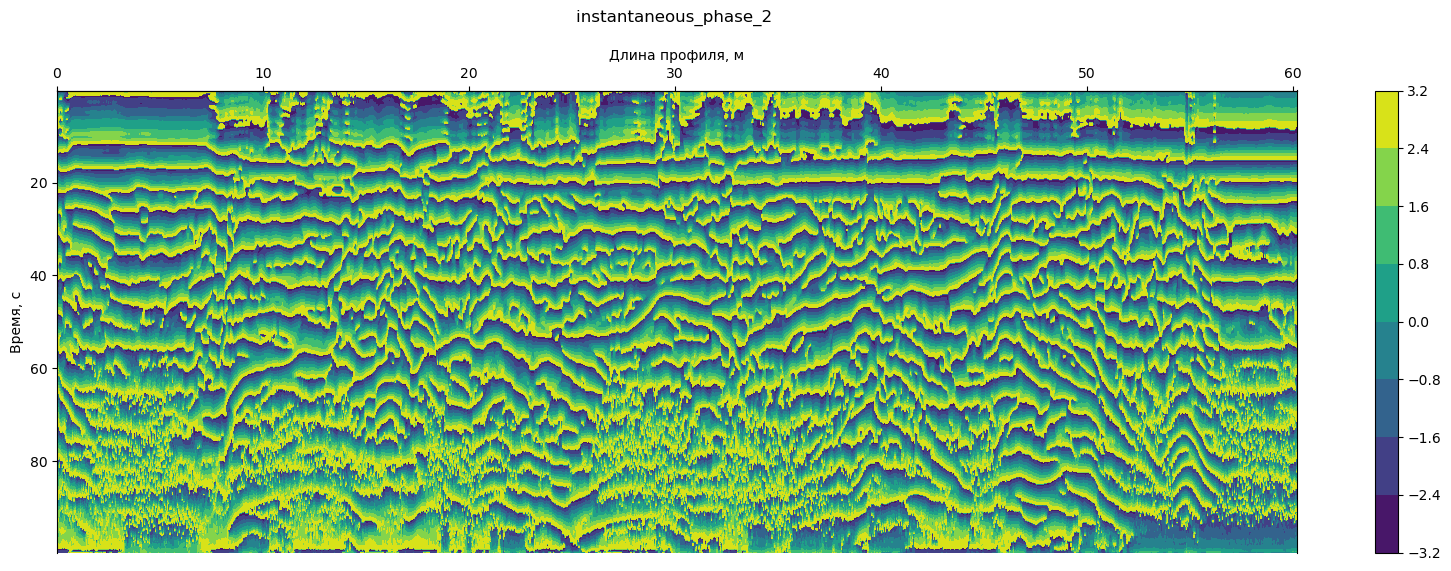

In [20]:
fig1 = plt.figure(figsize=(20, 6))
cf1 = plt.contourf(x_coord, time, instantaneous_phase_2.T)
plt.colorbar(cf1)
plt.title('instantaneous_phase_2 \n')

ax = plt.gca()
ax.invert_yaxis()
ax.spines['bottom'].set_position(('axes', 1))
ax.tick_params(axis='x', top=True, bottom=False, labelbottom=False, labeltop=True)
ax.set_xlabel('Длина профиля, м', labelpad=-30)
ax.set_ylabel('Время, с')
plt.show()

Идеально совпадает со старовойтовским примером.

### Вывод

Получилось обработать радарограмму с помощью преобразования Гильберта, результат совпал с примерами из учебника.